# Home Credit Default Risk Prediction
## 1. Problem Definition
Financial institutions face significant challenges in accurately evaluating the creditworthiness of applicants, particularly those with insufficient credit history. Traditional credit scoring models may not effectively capture risk factors for these individuals, leading to potential losses due to loan defaults. The objective of this project is to leverage supervised machine learning models to predict loan default risk. By incorporating machine learning techniques, financial institutions can enhance their lending decisions, minimize risk exposure, and improve the overall efficiency of credit assessment processes.
## 2. Objectives
- Conduct a thorough analysis and cleaning of the dataset to prepare it for modeling.
- Perform exploratory data analysis (EDA) to identify key patterns and insights.
- Train and evaluate multiple machine learning models to predict loan default risk.
- Compare the performance of different models and select the most effective one.
- Interpret the results to provide actionable insights for financial institutions.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve

The dataset being loaded, UCI_Credit_Card.csv, is a well-known dataset from the UCI Machine Learning Repository that contains information on credit card clients in Taiwan. It includes demographic details, payment history, bill statements, and the default payment status for the next month. This dataset is commonly used for classification tasks, particularly for predicting whether a customer will default on their payment.
The dataset can be downloaded from https://www.kaggle.com/datasets/xuandiluo/uci-credit-cardcsv

The target variable, default.payment.next.month, is a binary classification label indicating whether a customer will default (1) or not (0).

## 3. Importing data and cleaning data
In this section, we will import the **UCI Credit Card dataset** and examine its structure.  
The dataset contains information about credit card clients, including their **credit limit, demographic details, payment history, and bill amounts**.  

To begin, we will:
- Load the dataset using `pandas`
- Display the first few rows to understand the data
- Check the data types of each column to identify potential issues

In [8]:
# Load dataset
df = pd.read_csv('UCI_Credit_Card.csv') 
display(df.head())
print(df.dtypes)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object


Categorical variables (SEX, EDUCATION, MARRIAGE, PAY_0 to PAY_6, default.payment.next.month) are stored as int64, which is fine for encoding purposes.
Continuous/numeric variables (LIMIT_BAL, BILL_AMT1 to BILL_AMT6, PAY_AMT1 to PAY_AMT6) are stored as float64, which makes sense since they represent monetary values.
ID column is int64, which is expected.

In [5]:
# Check missing values
missing_values = df.isnull().sum()
display(missing_values[missing_values > 0])

Series([], dtype: int64)

The output indicates that after checking for missing values and filtering for columns with counts greater than zero, no missing data was found in the DataFrame.

In [6]:
print("\n📌 SUMMARY STATISTICS:")
print(df.describe())  # Basic statistics for numerical columns


📌 SUMMARY STATISTICS:
                 ID       LIMIT_BAL           SEX     EDUCATION      MARRIAGE  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      1.853133      1.551867   
std     8660.398374   129747.661567      0.489129      0.790349      0.521970   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7500.750000    50000.000000      1.000000      1.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      6.000000      3.000000   

                AGE         PAY_0         PAY_2         PAY_3         PAY_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      35.485500     -0.016700     -0.133767     -0.166200     -0.220667   
std       

In [16]:
# Data Cleaning with Logical Condition
missing_threshold = 0.5
min_non_null = int(missing_threshold * df.shape[0])

# Check if any column has missing values above the threshold
cols_to_drop = [col for col in df.columns if df[col].count() < min_non_null]

if cols_to_drop:
    df = df.drop(columns=cols_to_drop)
    print(f"Columns dropped: {len(cols_to_drop)}")
else:
    print("No columns needed cleaning. Data remains unchanged.")

# Summarize the data after cleaning
print("\n### Summary of Data After Cleaning ###")
print(f"DataFrame shape: {df.shape}")  # Print the shape (rows, columns)
print(f"Number of columns: {df.shape[1]}")  # Print the number of columns



No columns needed cleaning. Data remains unchanged.

### Summary of Data After Cleaning ###
DataFrame shape: (30000, 25)
Number of columns: 25


After examining the summary statistics of our dataset, we now have a clearer understanding of the distribution, central tendencies, and spread of our numerical variables. The next step is to further explore the dataset by visualizing key trends and identifying any potential anomalies. This will help us gain deeper insights and prepare the data for more advanced analysis. Let's proceed with some exploratory data analysis (EDA) techniques to uncover patterns and relationships within the dataset.


## 4. Exploratory Data Analysis (EDA)
EDA helps in understanding the dataset before training models. Visualizing distributions and correlations provides insights into important features.

-  The count plot visualizes the distribution of default and non-default cases in the dataset. This is a crucial step in Exploratory Data Analysis (EDA) as it provides insights into the balance of the target variable, helping us understand whether the dataset is skewed towards a particular class.

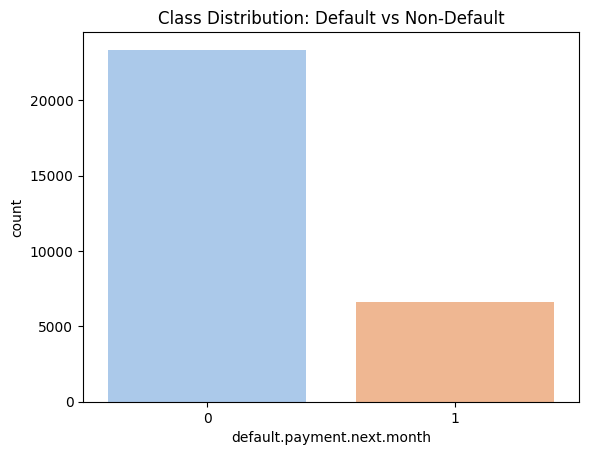

In [29]:
sns.countplot(x=df['default.payment.next.month'], hue=df['default.payment.next.month'], palette='pastel', legend=False)
plt.title('Class Distribution: Default vs Non-Default')
plt.show()

The bar chart illustrates the distribution of default vs. non-default cases in the dataset. A significant class imbalance is evident, with non-default cases (0) being much more frequent than default cases (1). This imbalance may affect the performance of predictive models, potentially leading to biased predictions favoring the majority class. Addressing this issue may require techniques such as resampling, cost-sensitive learning, or using evaluation metrics like F1-score and AUC-ROC to ensure a fair assessment of model performance.

- Next step, I want to have the visualization displays histograms for numerical features in your dataset, aiming to reveal their underlying distributions. However, the current presentation is cluttered and difficult to interpret due to inconsistent binning and scaling across variables. To improve clarity, consider separating categorical and numerical features, adjusting bin sizes, and utilizing subplots to organize the visualizations effectively. This will provide a more insightful and manageable view of your data's characteristics.

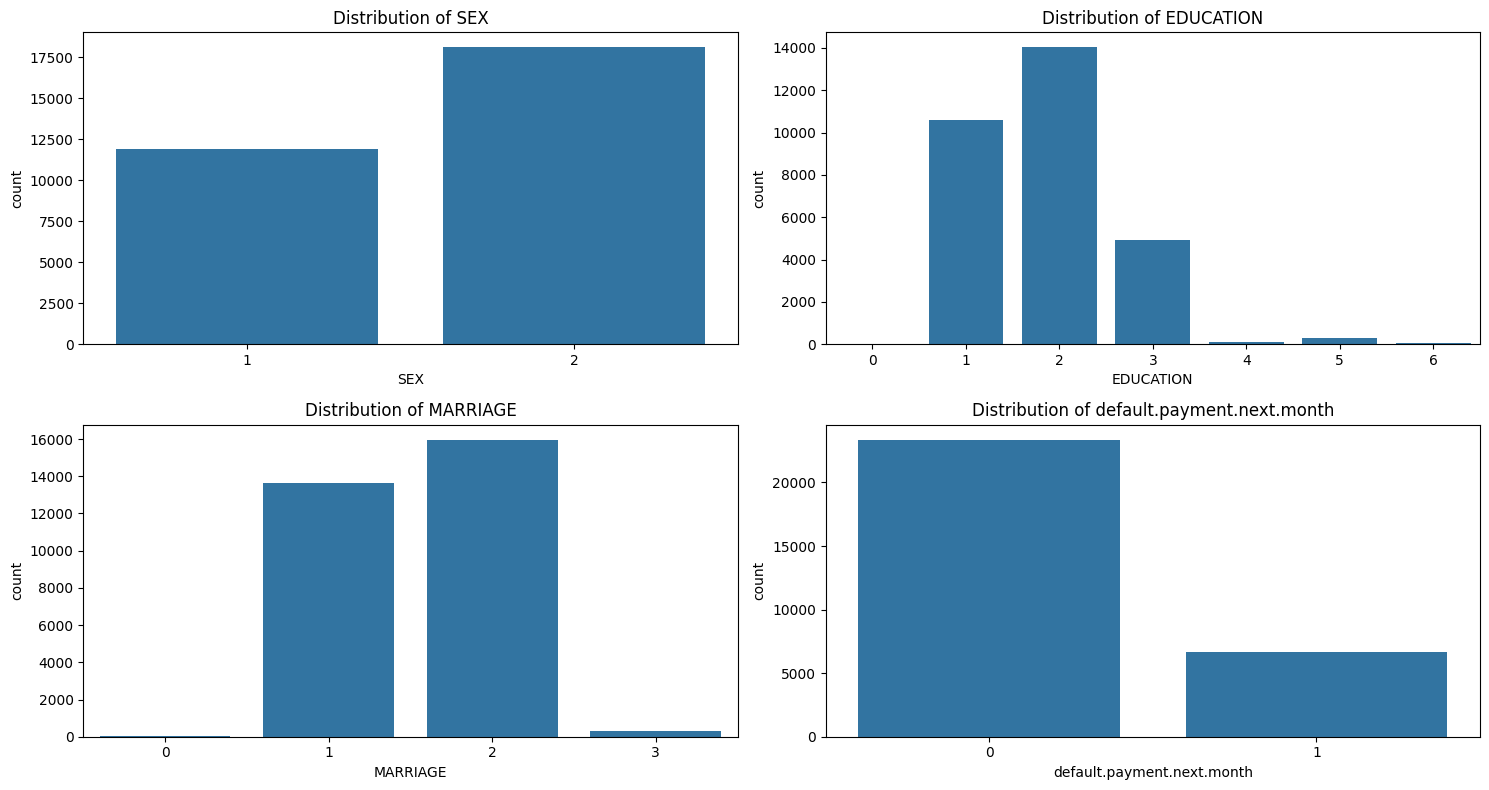

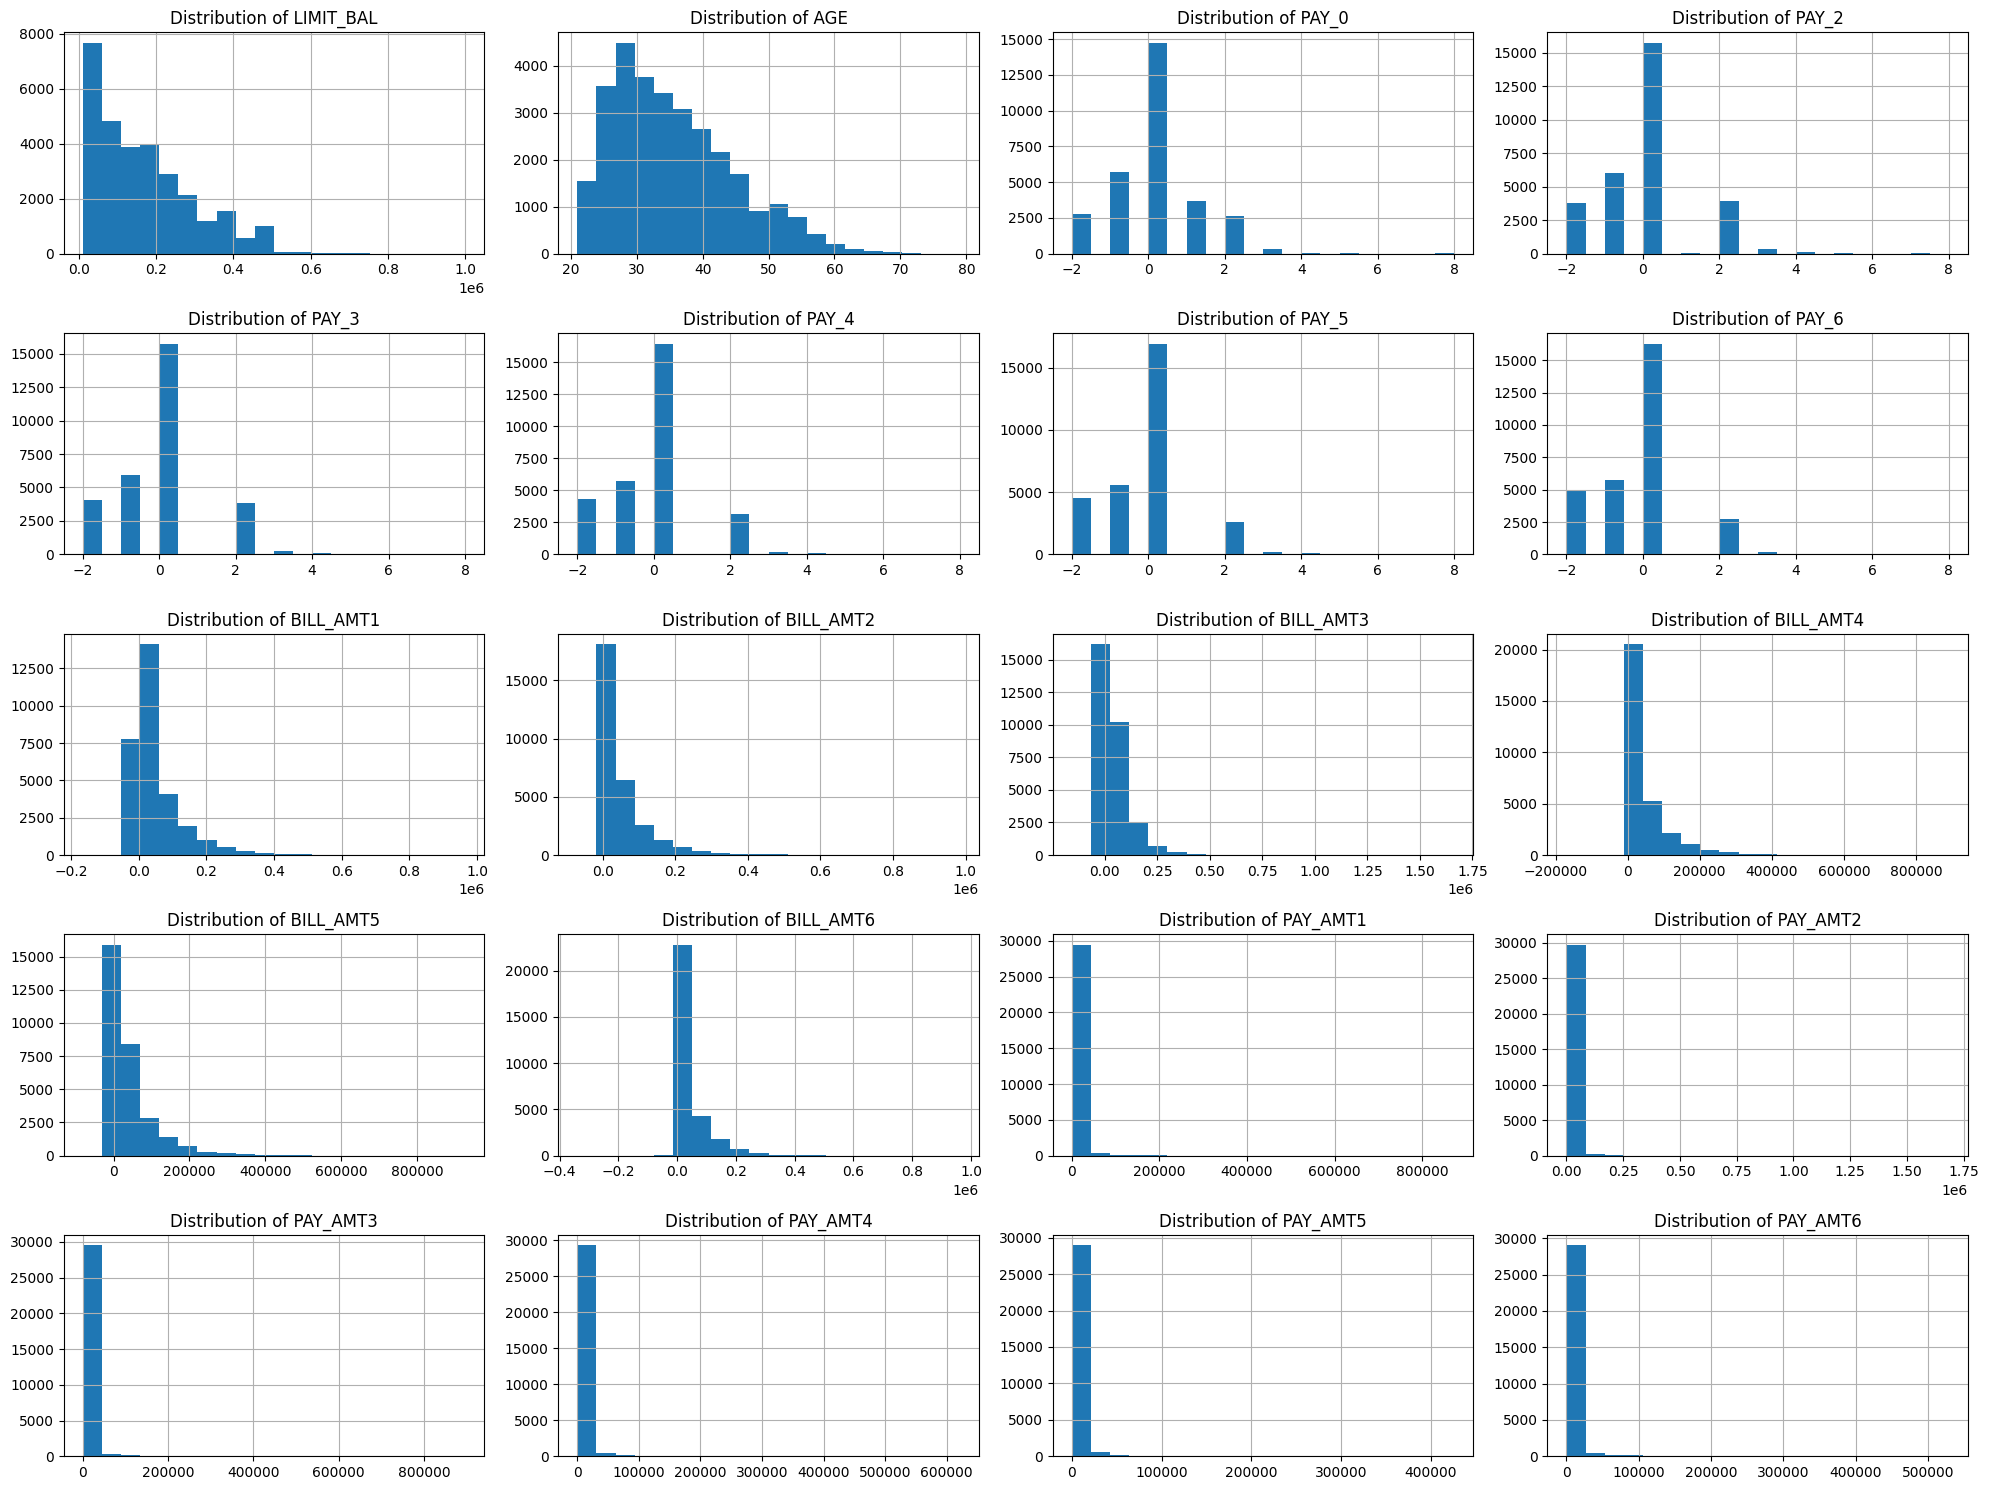

In [32]:
# Plot histogram for numerical variables
#df.hist(figsize=(12, 8), bins=30)
#plt.suptitle('Feature Distributions')
#plt.show()

# Separate categorical and numerical variables
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'default.payment.next.month']
numerical_cols = [col for col in df.columns if col not in categorical_cols and col != 'ID']  # Exclude 'ID'

# Visualize categorical variables using countplots
plt.figure(figsize=(15, 8))
for i, col in enumerate(categorical_cols):
    plt.subplot(2, 2, i + 1)
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Visualize numerical variables using histograms
plt.figure(figsize=(20, 15))

# Calculate the number of rows and columns for the subplot grid
num_cols = len(numerical_cols)
num_rows = (num_cols + 3) // 4  # Calculate rows needed for 4 columns per row

for i, col in enumerate(numerical_cols):
    plt.subplot(num_rows, 4, i + 1)  # Adjust subplot grid
    df[col].hist(bins=20)  # Adjust bins as needed
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

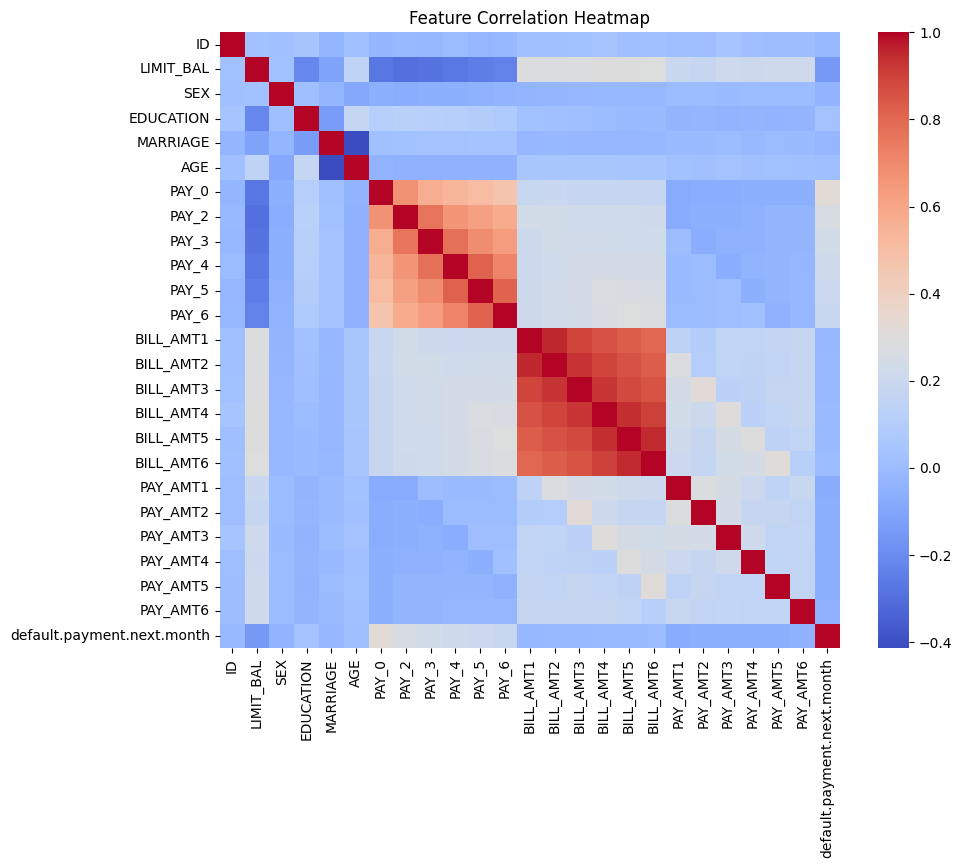

In [33]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

Overall, this heatmap helps in feature selection, suggesting that repayment history and bill amounts are key predictors of default risk, while demographic factors may have limited predictive power. Further analysis, such as feature engineering or model testing, would help determine the most important variables for improving predictive accuracy.

## 4. Model Training & Evaluation

Now we need to prepare the dataset for machine learning model training by performing key preprocessing steps to ensure better model performance and fairness. Here’s why each step is necessary:

- Feature and Target Selection:The dataset is split into features (X) and target variable (y). This is essential to separate independent variables from the dependent variable (default.payment.next.month), which the model will predict.

- Data Normalization: StandardScaler() is used to normalize numerical features, ensuring that all variables have a mean of 0 and a standard deviation of 1. This is crucial for models sensitive to feature scales, such as logistic regression and neural networks.

- Handling Class Imbalance:The dataset is resampled using SMOTE (Synthetic Minority Over-sampling Technique) to balance the default and non-default classes. Since imbalanced datasets can cause models to be biased toward the majority class, SMOTE generates synthetic samples for the minority class to improve predictive performance.

- Train-Test Split:The dataset is split into training and testing sets (80% training, 20% testing) using train_test_split(). This ensures the model is trained on one portion of the data while another unseen portion is used for evaluation, helping assess its generalization ability.
These steps are critical for building a robust and unbiased classification model that accurately predicts defaults while handling potential biases from imbalanced data.

In [34]:
# Feature and target selection
X = df.drop(columns=['default.payment.next.month'])
y = df['default.payment.next.month']

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

With the dataset now preprocessed, we can proceed to training and evaluating multiple machine learning models. This step involves fitting different classifiers to the training data and assessing their performance on the test set. By comparing various models, we can determine which algorithm best predicts defaults while balancing accuracy and fairness. We will evaluate the models using key classification metrics, including precision, recall, F1-score, and the AUC-ROC score, which measures the model’s ability to distinguish between default and non-default cases.

In [35]:
# Train and evaluate models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f'{name} Performance:')
    print(classification_report(y_test, y_pred))
    auc_score = roc_auc_score(y_test, y_prob)
    print(f'{name} AUC-ROC Score: {auc_score:.4f}\n')
    
    results[name] = {
        'AUC-ROC': auc_score,
        'Model': model
    }

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.66      0.69      0.67      4664
           1       0.67      0.65      0.66      4682

    accuracy                           0.67      9346
   macro avg       0.67      0.67      0.67      9346
weighted avg       0.67      0.67      0.67      9346

Logistic Regression AUC-ROC Score: 0.7260

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      4664
           1       0.88      0.83      0.86      4682

    accuracy                           0.86      9346
   macro avg       0.86      0.86      0.86      9346
weighted avg       0.86      0.86      0.86      9346

Random Forest AUC-ROC Score: 0.9312

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      4664
           1       0.90      0.81      0.85      4682

    accuracy         

Before plotting the ROC curves, it’s essential to visualize and compare the performance of our models beyond classification metrics. The ROC (Receiver Operating Characteristic) curve provides a graphical representation of a model’s ability to distinguish between default and non-default cases across different threshold values. By plotting the ROC curves for each model, we can analyze their trade-off between true positive rate (sensitivity) and false positive rate, helping us identify the most effective classifier. The AUC-ROC (Area Under the Curve - Receiver Operating Characteristic) score will also be displayed for each model, indicating its overall predictive power.

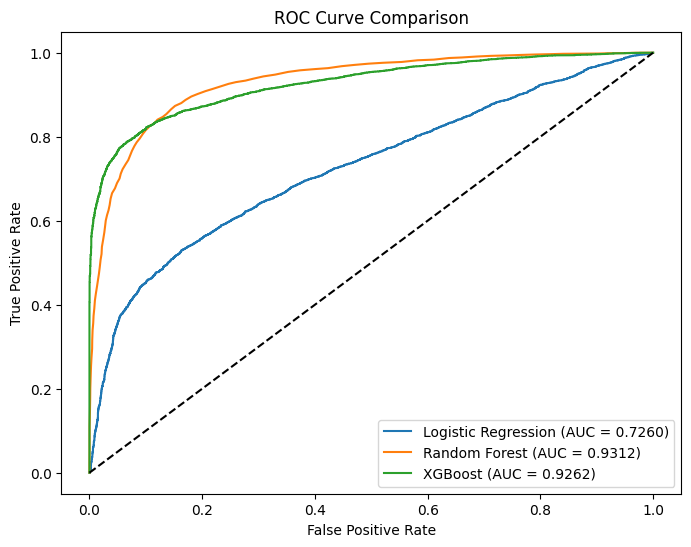

In [36]:
# Plot ROC Curves
plt.figure(figsize=(8, 6))
for name, model_data in results.items():
    y_prob = model_data['Model'].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {model_data['AUC-ROC']:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

## 5. Conclusion
The ROC Curve Comparison provides a visual evaluation of the classification performance of three models: Logistic Regression, Random Forest, and XGBoost. The AUC (Area Under the Curve) scores indicate the overall effectiveness of each model in distinguishing between default and non-default cases.

Model Performance:

Random Forest (AUC = 0.9312) demonstrates the best performance, showing a strong ability to differentiate between classes.
XGBoost (AUC = 0.9262) is slightly lower than Random Forest but still highly effective, indicating its robustness in handling complex relationships.
Logistic Regression (AUC = 0.7260) performs significantly worse than the other two models, suggesting that it may not capture the non-linear relationships in the data effectively.
Comparison of ROC Curves:

The Random Forest and XGBoost curves are closer to the top-left corner, indicating higher sensitivity and specificity, making them superior choices for this classification task.
Logistic Regression has a much lower curve, suggesting higher false positive and false negative rates, making it less reliable in this scenario.
The diagonal dashed line represents a random classifier (AUC = 0.5), meaning all models perform significantly better than random guessing.
Key Takeaways:
Random Forest and XGBoost are both strong contenders, with minimal difference in AUC, making them ideal for predicting defaults.
Logistic Regression may not be suitable for this problem due to its lower AUC, possibly requiring feature engineering or more complex transformations.
The final model choice should consider interpretability, computational cost, and generalization on unseen data to ensure the best balance between performance and usability.


## 6. Future Improvements
- Conduct **feature engineering** to enhance predictive power.
- Perform **hyperparameter tuning** for better model optimization.
- Explore **deep learning approaches** to improve accuracy further.
By implementing these machine learning techniques, financial institutions can improve risk assessment strategies and make more informed lending decisions.